In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import seaborn as sns
from PIL import Image
from numpy import asarray
import tensorflow as tf
np.set_printoptions(precision=5)#show 5 number after decimal point 

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [3]:
classes = ['non-vehicles','vehicles']

In [4]:
def upload_data(vehicle_dir, non_vehicle_dir):
    data = []
    
    # Upload vehicle images
    for img_name in tqdm(os.listdir(vehicle_dir)):
        img_path = os.path.join(vehicle_dir, img_name)
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        resized_image = image.resize((128, 128))  # Resize image
        image_array = np.asarray(resized_image)
        data.append([image_array, 1])  # Label 1 for vehicles
    
    # Upload non-vehicle images
    for img_name in tqdm(os.listdir(non_vehicle_dir)):
        img_path = os.path.join(non_vehicle_dir, img_name)
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        resized_image = image.resize((128, 128))  # Resize image
        image_array = np.asarray(resized_image)
        data.append([image_array, 0])  # Label 0 for non-vehicles
    
    # Convert data to a NumPy array
    data = np.array(data, dtype=object)
    
    return data

# Define the paths
vehicles_url = r"data\vehicles"
non_vehicles_url = r"data\non-vehicles"

In [5]:
# Upload the data
data = upload_data(vehicles_url, non_vehicles_url)

100%|█████████████████████████████████████████████████████████████████████████████| 8968/8968 [00:09<00:00, 927.97it/s]


In [6]:
def extract_features_labels(data):
    X = []
    y = []

    for image_array, label in data:
        X.append(image_array)
        y.append(label)

    X = np.array(X)
    y = np.array(y)

    return X, y


In [7]:
# Extract features (X) and labels (y)
X, y = extract_features_labels(data)

Text(0.5, 1.0, 'Not-Vehicle')

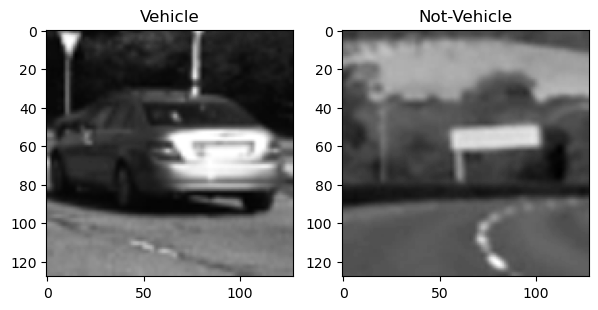

In [8]:
fig = plt.figure(figsize=(7, 7))
  
fig.add_subplot(1, 2, 1)
plt.imshow(X[3,:], cmap=plt.get_cmap('gray'))
plt.title("Vehicle")

fig.add_subplot(1, 2, 2)
plt.imshow(X[9000,:], cmap=plt.get_cmap('gray'))
plt.title("Not-Vehicle")

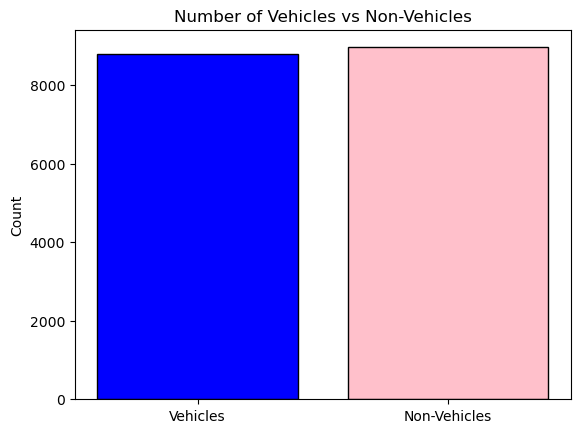

In [9]:
# Count the number of vehicles (label 1) and non-vehicles (label 0)
num_vehicles = np.sum(y == 1)
num_non_vehicles = np.sum(y == 0)

# Plot the counts using plt.bar()
plt.bar(['Vehicles', 'Non-Vehicles'], [num_vehicles, num_non_vehicles], color=['blue', 'pink'],linewidth=1, edgecolor="black")
plt.ylabel('Count')
plt.title('Number of Vehicles vs Non-Vehicles')
plt.show()

In [10]:
X = X/255.0

In [11]:
print(X.shape)
print(y.shape)

(17760, 128, 128)
(17760,)


In [12]:
X = X.reshape((17760, 128*128))

In [13]:
#split the data to train and test 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
#split the train
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.3, random_state=42)

In [14]:
# Before we try real models, we will try a dummyClassifier. we will try to get high score than the dummyModel.
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_val)
print("The DummyClassifier score is:" ,round(accuracy_score(y_pred,y_val),3))

The DummyClassifier score is: 0.502


In [15]:
import tensorflow as tf
from sklearn.metrics import accuracy_score

# Define logistic regression model using TensorFlow 2.x
class LogisticRegression(tf.keras.Model):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.flatten = tf.keras.layers.Flatten(input_shape=(128, 128))  # Flatten input images
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer with sigmoid activation

    def call(self, x):
        x = self.flatten(x)
        return self.dense(x)

# Create an instance of the logistic regression model
model = LogisticRegression()

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test Accuracy:", test_acc)

# Predictions on the test set
y_pred_prob = model.predict(X_test)

# Convert probabilities to class labels based on a threshold (e.g., 0.5)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)



Epoch 1/50


272/272 [==============================] - 6s 8ms/step - loss: 0.5189 - accuracy: 0.7750 - val_loss: 0.4105 - val_accuracy: 0.8330
Epoch 2/50
272/272 [==============================] - 1s 5ms/step - loss: 0.3848 - accuracy: 0.8431 - val_loss: 0.3861 - val_accuracy: 0.8501
Epoch 3/50
272/272 [==============================] - 1s 5ms/step - loss: 0.3898 - accuracy: 0.8360 - val_loss: 0.5289 - val_accuracy: 0.7335
Epoch 4/50
272/272 [==============================] - 1s 5ms/step - loss: 0.3978 - accuracy: 0.8397 - val_loss: 0.3714 - val_accuracy: 0.8566
Epoch 5/50
272/272 [==============================] - 1s 5ms/step - loss: 0.3662 - accuracy: 0.8543 - val_loss: 0.4228 - val_accuracy: 0.8193
Epoch 6/50
272/272 [==============================] - 1s 5ms/step - loss: 0.3518 - accuracy: 0.8551 - val_loss: 0.4119 - val_accuracy: 0.8542
Epoch 7/50
272/272 [==============================] - 1s 5ms/step - loss: 0.3468 - accuracy: 0.8623 - val_loss: 0.3689 - val_accuracy: 0.8574
Ep